# **2022년 빅데이터 동아리 (2022년 9월 26일)**

- 경진대회 참가: 내부 빅데이터-IP 관련 경진대회가 있을 예정 (지식재산, 발명, 특허 분석)
- 제2회 빅데이터로 우리동네 문제해결 아이디어 공모대회: https://www.smart-usg.or.kr/board/notice/show/290 (마감: 9월 30일)
- 그 외 경진대회 참가를 희망하는 학생은 주제를 선정하기 바랍니다.
- 취업을 위한 코딩 테스트 연습 

한국어 웹사이트: https://programmers.co.kr/  --> 연습 추천

영어 웹사이트: https://checkio.org/

# Streamlit 활용한 데이터 분석 웹사이트 생성

## **1. Streamlit 설치하기 (The fastest way to build and share data apps) + ngrok 설치하기**

In [ ]:
!pip install -q streamlit

In [ ]:
!pip install -q pyngrok # 로컬 개발 환경을 외부에 공유하게 도와주는 라이브러리

In [ ]:
!pip install -q yfinance # 주식데이터 다운을 위한 라이브러리

## **2. https://ngrok.com/ 에서 가입하기** (구글 계정으로 바로 가입 가능)

**Authtoken 기억하기**

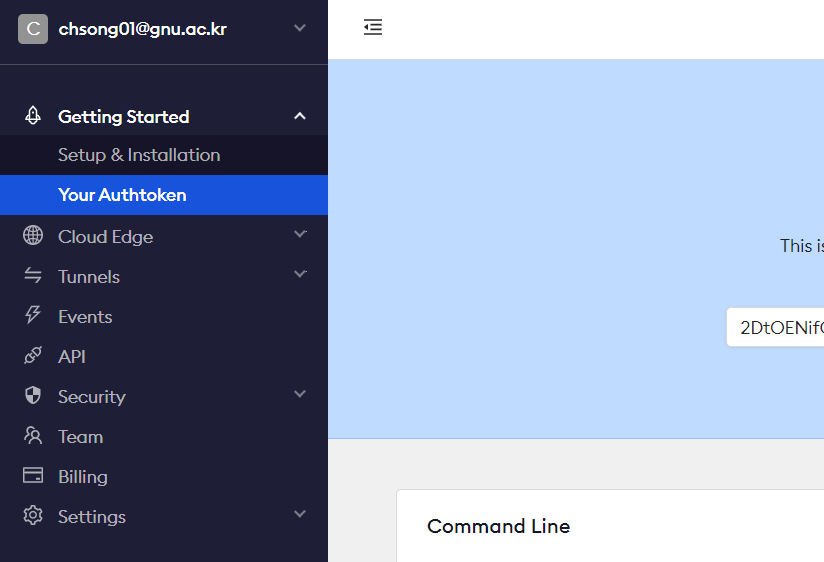

In [ ]:
from pyngrok import ngrok 

In [ ]:
ngrok.set_auth_token("") # 개인 토큰을 삽입해 주세요

## **3-1. App 프로그래밍 (주식 가격을 나타내주는 앱)**

In [ ]:
%%writefile first_app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf

st.write("""
# Simple Stock Price App
Shown are the stock **closing price** and ***volume*** of Google!
""")


# Define the ticker symbol
tickerSymbol = 'GOOGL'
# get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-5-31', end='2020-5-31')
# Open	High	Low	Close	Volume	Dividends	Stock Splits

st.write("""
## Closing Price
""")
st.line_chart(tickerDf.Close)
st.write("""
## Volume Price
""")
st.line_chart(tickerDf.Volume)

Overwriting first_app.py


## **3-2. App 프로그래밍 (주식 가격을 나타내주는 앱, 더 복잡한 버전)**

아래버전은 추후에 테스트 

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import plotly.express as px

st.title('S&P 500 App')

st.markdown("""
This app retrieves the list of the **S&P 500** (from Wikipedia) and its corresponding **stock closing price** (year-to-date)!
* **Python libraries:** base64, pandas, streamlit, numpy, matplotlib, seaborn, plotly
* **Data source:** [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).
""")

st.sidebar.header('User Input Features')

# Web scraping of S&P 500 data
#
@st.cache
def load_data():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html = pd.read_html(url, header = 0)
    df = html[0]
    df = df.drop_duplicates(subset=['Symbol'])
    return df

df = load_data()
sector = df.groupby('GICS Sector')

# Sidebar - Sector selection
sorted_sector_unique = sorted( df['GICS Sector'].unique() )
selected_sector = st.sidebar.multiselect('Sector', sorted_sector_unique, sorted_sector_unique)


# Filtering data
df_selected_sector = df[ (df['GICS Sector'].isin(selected_sector)) ]

st.header('Display Companies in Selected Sector')
st.write('Data Dimension: ' + str(df_selected_sector.shape[0]) + ' rows and ' + str(df_selected_sector.shape[1]) + ' columns.')
st.dataframe(df_selected_sector)

# Download S&P500 data
# https://discuss.streamlit.io/t/how-to-download-file-in-streamlit/1806
def filedownload(df):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()  # strings <-> bytes conversions
    href = f'<a href="data:file/csv;base64,{b64}" download="SP500.csv">Download CSV File</a>'
    return href

st.markdown(filedownload(df_selected_sector), unsafe_allow_html=True)

data = yf.download(
        tickers = list(df_selected_sector[:10].Symbol),
        period = "ytd",
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None
    )

# Plot Closing Price of Query Symbol
def price_plot(symbol):
  df = pd.DataFrame(data[symbol].Close)
  df['Date'] = df.index
  fig, ax = plt.subplots()
  plt.fill_between(df.Date, df.Close, color='skyblue', alpha=0.3)
  ax.plot(df.Date, df.Close, color='skyblue', alpha=0.8)
  plt.xticks(rotation=90)
  plt.title(symbol, fontweight='bold')
  plt.xlabel('Date', fontweight='bold')
  plt.ylabel('Closing Price', fontweight='bold')
  return st.pyplot(fig)

num_company = st.sidebar.slider('Number of Companies', 1, 10)
user_input = st.sidebar.text_input('Input Company (Symbol) - Default value is AAPL','AAPL')
start_date = st.sidebar.text_input('Collecting stock data - starting from 2018-01-01', '2018-01-01')
end_date = st.sidebar.text_input('Collecting stock data - till 2022-07-31','2022-07-31')

df_single = yf.download(tickers = user_input,
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None, start=start_date, end=end_date)
df_single['Date'] = df_single.index

if st.button('Show Plots'):
    st.header('Stock Closing Price')
    for i in list(df_selected_sector.Symbol)[:num_company]:
        price_plot(i)

# st.dataframe(df_single)

if st.button('Show Single Stock History'):
    st.header('Stock Closing Price')

    st.write('This chart is for ' + str(df[df['Symbol'] == user_input]['Security'].values[0]) + '.')
    fig = px.line(df_single, x='Date', y='Close')
    st.plotly_chart(fig)
    


Writing app.py


In [ ]:
!ls # 앱 파일이 생성되었는지 확인

app.py	first_app.py  nohup.out  sample_data


## **4. Streamlit과 ngrok 연결**

In [ ]:
# 이부분의 앱이름을 바꿔 주어야 함
!nohup streamlit run first_app.py --server.port 80 &
url = ngrok.connect(port='80')
print(url)

nohup: appending output to 'nohup.out'
NgrokTunnel: "http://ef8f-34-145-3-249.ngrok.io" -> "http://localhost:80"


In [ ]:
tunnels = ngrok.get_tunnels()
tunnels

[<NgrokTunnel: "https://ef8f-34-145-3-249.ngrok.io" -> "http://localhost:80">,
 <NgrokTunnel: "http://ef8f-34-145-3-249.ngrok.io" -> "http://localhost:80">]

In [ ]:
ngrok.kill() # 종료시 항상 실행